All libraries are ready.
--- Unzipping Datasets ---
Dataset 'parkinsons_multimodal_data' (combined_dastaset_1.zip) already exists.
Dataset 'mri_data_1' (mri_1.zip) already exists.
Dataset 'mri_data_2' (mri_2.zip) already exists.
Dataset 'mri_data_3' (mri_3.zip) already exists.
--- Unzipping complete ---

Loading dataset 1 (Structural MRI)...
Found 831 images from dataset 1.

Loading dataset 2 (Structural MRI)...
Found 831 images from dataset 2.

Loading dataset 3 (Structural MRI)...
Found 241 images from dataset 3.

Loading dataset 4 (Structural MRI .nii files)...
Found 60 images from dataset 4.
NOTE: Skipped Datscan and Prodromal images from dataset 4.

Total combined structural MRI images: 1963
Total data: 1963 images
Training set: 1256 images
Validation set: 314 images
Final Test set: 393 images

--- Training Final MRI Model (Monitored by Validation Set) ---

--- Starting training with 1256 training images and 314 validation images. ---

--- Phase 1: Training classifier head ---
Epo

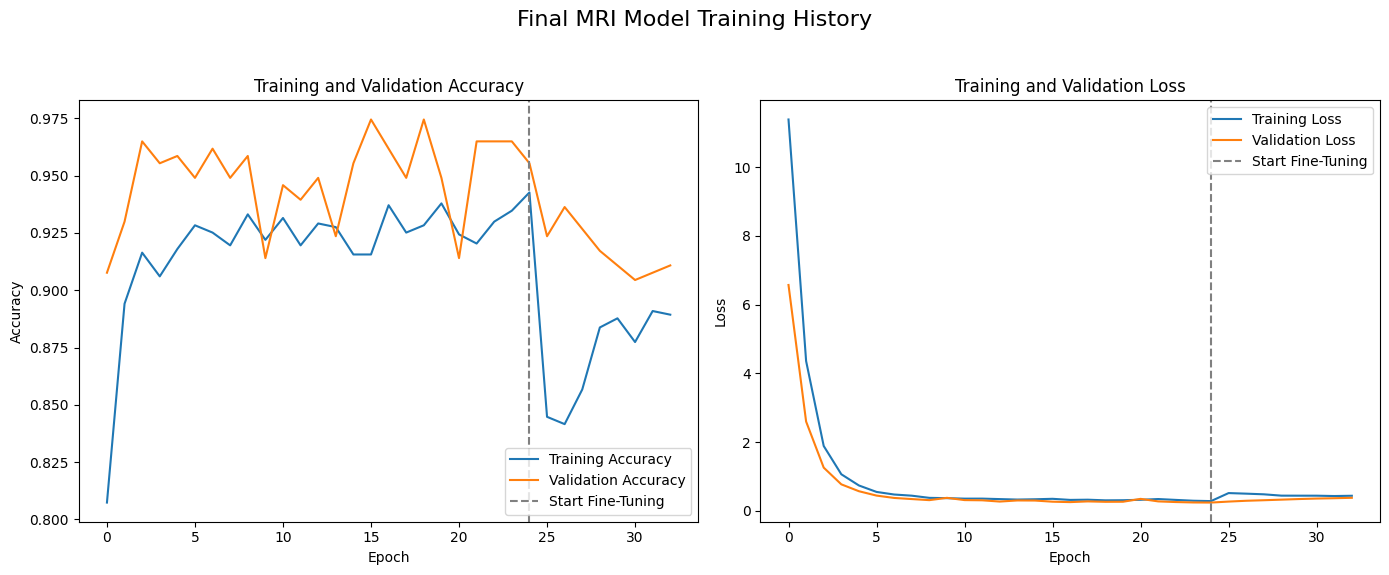

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.pyplot as plt
import zipfile
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np

# --- 1. NEW: INSTALL REQUIRED LIBRARIES ---
import subprocess
import sys
try:
    import nibabel as nib
    import scipy
except ImportError:
    print("Installing required libraries: nibabel, scipy")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nibabel", "scipy"])
    import nibabel as nib
    import scipy
    
print("All libraries are ready.")


# --- 2. SETUP CELL: UNZIP ALL FOUR DATASETS ---
print("--- Unzipping Datasets ---")

zip_path_1 = '../combined_dastaset_1.zip' 
data_dir_1 = 'parkinsons_multimodal_data'
if not os.path.exists(data_dir_1):
    print(f"Unzipping '{zip_path_1}'...")
    with zipfile.ZipFile(zip_path_1, 'r') as zip_ref:
        zip_ref.extractall(data_dir_1)
else:
    print(f"Dataset '{data_dir_1}' (combined_dastaset_1.zip) already exists.")

zip_path_2 = '../mri_1.zip' 
data_dir_2 = 'mri_data_1'
if not os.path.exists(data_dir_2):
    print(f"Unzipping '{zip_path_2}'...")
    with zipfile.ZipFile(zip_path_2, 'r') as zip_ref:
        zip_ref.extractall(data_dir_2)
else:
    print(f"Dataset '{data_dir_2}' (mri_1.zip) already exists.")

zip_path_3 = '../mri_2.zip'
data_dir_3 = 'mri_data_2'
if not os.path.exists(data_dir_3):
    print(f"Unzipping '{zip_path_3}'...")
    with zipfile.ZipFile(zip_path_3, 'r') as zip_ref:
        zip_ref.extractall(data_dir_3)
else:
    print(f"Dataset '{data_dir_3}' (mri_2.zip) already exists.")

zip_path_4 = '../mri_3.zip' 
data_dir_4 = 'mri_data_3' 
if not os.path.exists(data_dir_4):
    print(f"Unzipping '{zip_path_4}'...")
    with zipfile.ZipFile(zip_path_4, 'r') as zip_ref:
        zip_ref.extractall(data_dir_4)
else:
    print(f"Dataset '{data_dir_4}' (mri_3.zip) already exists.")

print("--- Unzipping complete ---")


# --- 3. DATA AGGREGATION CELL: COMBINE ALL *STRUCTURAL MRI* DATA ---
all_image_paths = []
all_labels = []

# Load from dataset 1 (combined_dastaset_1.zip)
print("\nLoading dataset 1 (Structural MRI)...")
ds1_base_path = os.path.join(data_dir_1, 'Parkinson Multi Model DATASET') 
class_map_ds1 = {"Healthy": 0, "Unhealthy": 1}
mri_subfolders_ds1 = {
    "Healthy": ["Healthy/MRI 1 HEALTHY", "Healthy/MRI 2 HEALTHY"], 
    "Unhealthy": ["Unhealthy/MRI 1 UNHEALTHY", "Unhealthy/MRI 2 UNHEALTHY"] 
}
initial_count_ds1 = len(all_image_paths)
for class_name, label in class_map_ds1.items():
    for folder in mri_subfolders_ds1[class_name]:
        folder_path = os.path.join(ds1_base_path, folder)
        if os.path.exists(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_image_paths.append(os.path.join(folder_path, filename))
                    all_labels.append(label)
print(f"Found {len(all_image_paths) - initial_count_ds1} images from dataset 1.")

# Load from dataset 2 (mri_1.zip)
print("\nLoading dataset 2 (Structural MRI)...")
ds2_base_path = os.path.join(data_dir_2, 'parkinsons_dataset') 
ds2_folders = ['normal', 'parkinson'] 
initial_count_ds2 = len(all_image_paths)
for folder in ds2_folders:
    label = 0 if 'normal' in folder else 1 
    full_path = os.path.join(ds2_base_path, folder)
    if os.path.exists(full_path):
        for filename in os.listdir(full_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(full_path, filename))
                all_labels.append(label)
    else:
        print(f"WARNING: Dataset 2 folder not found at: {full_path}")
print(f"Found {len(all_image_paths) - initial_count_ds2} images from dataset 2.")

# Load from Dataset 3 (mri_2.zip)
print("\nLoading dataset 3 (Structural MRI)...")
ds3_base_path = os.path.join(data_dir_3, 'Disease_Prediction-20231213T083430Z-001', 'Disease_Prediction') 
ds3_folders = ['HC_new', 'PD_new'] 
initial_count_ds3 = len(all_image_paths)
for folder in ds3_folders:
    label = 0 if 'HC_new' in folder else 1 
    full_path = os.path.join(ds3_base_path, folder)
    if os.path.exists(full_path):
        for filename in os.listdir(full_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(full_path, filename))
                all_labels.append(label)
    else:
        print(f"WARNING: Dataset 3 folder not found at: {full_path}")
print(f"Found {len(all_image_paths) - initial_count_ds3} images from dataset 3.")

# Load from dataset 4 (mri_3.zip - .nii files)
print("\nLoading dataset 4 (Structural MRI .nii files)...")
ds4_base_path = os.path.join(data_dir_4, 'mri_datscan_ppmi', 'Mri') 
ds4_folders_to_load = {
    'control-30': 0, # path: label
    'PD-30': 1       # path: label
}
initial_count_ds4 = len(all_image_paths)
for folder, label in ds4_folders_to_load.items():
    full_path = os.path.join(ds4_base_path, folder)
    if os.path.exists(full_path):
        for filename in os.listdir(full_path):
            if filename.lower().endswith(('.nii', '.nii.gz')):
                all_image_paths.append(os.path.join(full_path, filename))
                all_labels.append(label)
    else:
        print(f"WARNING: Dataset 4 folder not found at: {full_path}")
print(f"Found {len(all_image_paths) - initial_count_ds4} images from dataset 4.")
print(f"NOTE: Skipped Datscan and Prodromal images from dataset 4.")


print(f"\nTotal combined structural MRI images: {len(all_image_paths)}")
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# --- 4. NEW 3-WAY DATA SPLIT ---
train_val_paths, final_test_paths, train_val_labels, final_test_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.20, 
    random_state=42,
    stratify=all_labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.20, 
    random_state=42,
    stratify=train_val_labels
)
print(f"Total data: {len(all_image_paths)} images")
print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Final Test set: {len(final_test_paths)} images")


# --- 5. DEFINE TF DATASET CREATION FUNCTION (UPDATED FOR NIFTI) ---
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def _py_load_and_preprocess_image(path_tensor, label_tensor):
    path_str = path_tensor.numpy().decode('utf-8')
    try:
        if path_str.lower().endswith(('.nii', '.nii.gz')):
            img = nib.load(path_str)
            data = img.get_fdata()
            if data.max() > 0:
                data = data / data.max()
            data = data * 255.0
            slice_idx = data.shape[-1] // 2
            img_slice = data[..., slice_idx]
            img_slice_resized = scipy.ndimage.zoom(img_slice, (IMG_SIZE / img_slice.shape[0], IMG_SIZE / img_slice.shape[1]), order=1)
            image_array = np.stack((img_slice_resized,) * 3, axis=-1)
        elif path_str.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_bytes = tf.io.read_file(path_str)
            image_tensor = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
            image_tensor_resized = tf.image.resize(image_tensor, [IMG_SIZE, IMG_SIZE])
            image_array = image_tensor_resized.numpy()
        else:
            print(f"Warning: Skipping unknown or corrupted file: {path_str}")
            image_array = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        image_array = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    return image_array.astype(np.float32), label_tensor

@tf.function
def tf_load_and_preprocess_image(path, label):
    output_types = [tf.float32, tf.int64]
    [image, label] = tf.py_function(
        _py_load_and_preprocess_image, 
        [path, label],                 
        output_types                   
    )
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label.set_shape([])
    return image, label

def create_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(tf_load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

def create_train_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(tf_load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset


# --- 6. DEFINE MODEL BUILDING FUNCTION (AGGRESSIVE REGULARIZATION) ---
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # --- MORE AGGRESSIVE DATA AUGMENTATION ---
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15), # Increased from 0.1
        layers.RandomZoom(0.15), # Increased from 0.1
        layers.RandomContrast(0.15), # Increased from 0.1
    ], name="data_augmentation")

    base_model = Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = data_augmentation(inputs)
    x = tf.keras.applications.xception.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    # --- STRONGER L2 REGULARIZATION ---
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x) # Increased from 0.01
    x = layers.Dropout(0.6)(x) # Keeping 0.6 dropout
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model, base_model

# --- 7. NEW: SINGLE, ROBUST TRAINING RUN ---
print("\n--- Training Final MRI Model (Monitored by Validation Set) ---")

if len(train_paths) == 0 or len(val_paths) == 0 or len(final_test_paths) == 0:
    print("\n" + "="*60)
    print("ERROR: No images were loaded into the training, validation, or test sets.")
    print("This is likely due to incorrect paths in the 'DATA AGGREGATION CELL' (Cell 3).")
    print("Please manually check your unzipped folders and correct the paths in Cell 3.")
    print("="*60)
else:
    print(f"\n--- Starting training with {len(train_paths)} training images and {len(val_paths)} validation images. ---")
    
    train_ds = create_train_dataset(train_paths, train_labels)
    val_ds = create_dataset(val_paths, val_labels)
    final_test_ds = create_dataset(final_test_paths, final_test_labels)

    model, base_model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stopper_1 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

    print("\n--- Phase 1: Training classifier head ---")
    history = model.fit(
        train_ds,
        epochs=25, 
        validation_data=val_ds,
        callbacks=[early_stopper_1],
        verbose=1
    )

    print("\n--- Phase 2: Starting Fine-Tuning ---")
    base_model.trainable = True
    # Fine-tune the last 30 layers
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-8)
    early_stopper_2 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

    start_epoch = len(history.history['loss']) if history.history else 0

    history_fine = model.fit(
        train_ds,
        epochs=start_epoch + 30, 
        initial_epoch=start_epoch,
        validation_data=val_ds,
        callbacks=[lr_scheduler, early_stopper_2],
        verbose=1
    )

    # --- 8. FINAL EVALUATION ON THE HELD-OUT TEST SET ---
    print("\n--- Evaluating Best Model on the Held-Out Test Set ---")
    final_loss, final_accuracy = model.evaluate(final_test_ds, verbose=1)

    print("\n" + "="*60)
    print(f"Final Model Performance on Unseen Test Set:")
    print(f"Test Accuracy: {final_accuracy * 100:.2f}%")
    print(f"Test Loss: {final_loss:.4f}")
    print("="*60)

    # --- 9. SAVE THE FINAL, BEST MODEL (FIXED) ---
    # FIX: Added include_optimizer=False to prevent 'TrueDivide' error
    model.save('mri_model.keras')
    print("\nFinal combined MRI model saved as 'mri_model.keras'")

    # --- 10. PLOT FINAL MODEL TRAINING HISTORY ---
    final_history_combined = {}

    if history.history and hasattr(history_fine, 'history'):
        all_keys = set(history.history.keys()) | set(history_fine.history.keys())
        for key in all_keys:
            history_1_data = history.history.get(key, [])
            history_2_data = history_fine.history.get(key, [])
            final_history_combined[key] = history_1_data + history_2_data
    elif history.history:
        final_history_combined = history.history
    else:
        print("No training history to plot.")

    acc = final_history_combined.get('accuracy', [])
    val_acc = final_history_combined.get('val_accuracy', [])
    loss = final_history_combined.get('loss', [])
    val_loss = final_history_combined.get('val_loss', [])

    epochs_range = range(len(acc))

    if epochs_range: # Only plot if there is history
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        if acc and val_acc:
            plt.plot(epochs_range, acc, label='Training Accuracy')
            plt.plot(epochs_range, val_acc, label='Validation Accuracy')
            if start_epoch > 0:
                plt.axvline(start_epoch - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
            plt.legend(loc='lower right')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
        else:
             plt.text(0.5, 0.5, 'Accuracy data not available', ha='center', va='center')

        plt.subplot(1, 2, 2)
        if loss and val_loss:
            plt.plot(epochs_range, loss, label='Training Loss')
            plt.plot(epochs_range, val_loss, label='Validation Loss')
            if start_epoch > 0:
                plt.axvline(start_epoch - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
            plt.legend(loc='upper right')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
        else:
             plt.text(0.5, 0.5, 'Loss data not available', ha='center', va='center')

        plt.suptitle('Final MRI Model Training History', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No training history to plot.")